In [1]:
# Standard Libraries
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split

# Scikit-learn Libraries for Evaluation
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE

# PIL for Image Processing
from PIL import Image

# Set Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


In [2]:
# Define dataset paths
dataset_path = r"E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images" # Change to your actual dataset path

# Define transformations
image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
])

# Custom Dataset Class for Milling Machine Scalograms
class MillingScalogramDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load images from each class folder
        class_folders = sorted(os.listdir(dataset_path))  # Ensure consistent class order
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_folders)}

        for cls_name in class_folders:
            cls_path = os.path.join(dataset_path, cls_name)
            if os.path.isdir(cls_path):
                for img_file in glob.glob(os.path.join(cls_path, "*.png")):
                    self.image_paths.append(img_file)
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

# Load dataset
milling_dataset = MillingScalogramDataset(dataset_path, transform=image_transforms)

# Split dataset into Train (80%), Validation (10%), Test (10%)
train_size = int(0.6 * len(milling_dataset))
val_size = int(0.1 * len(milling_dataset))
test_size = len(milling_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(milling_dataset, [train_size, val_size, test_size])

# Define batch size
BATCH_SIZE = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Dataset Loaded: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")


✅ Dataset Loaded: Train=168, Validation=28, Test=84


In [3]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim=100, image_size=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, image_size=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


# Initialize Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100  # Latent space dimension

generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

print("✅ SAGAN Generator & Discriminator Initialized!")


✅ SAGAN Generator & Discriminator Initialized!


In [4]:
# Xavier Initialization for Stability
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.xavier_normal_(m.weight.data)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.00005  # Lower LR for stable training
beta1 = 0.5

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

print("✅ Optimizers & Loss Function Set!")


✅ Optimizers & Loss Function Set!


In [5]:
# Training Parameters
num_epochs = 50
BATCH_SIZE = 32
fixed_noise = torch.randn(16, noise_dim, 1, 1, device=device)

# Start Training
for epoch in range(num_epochs):
    start_time = time.time()
    
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)

        # **Soft Labels**
        real_labels = torch.full((real_images.size(0), 1), 0.9, device=device)  # Real labels = 0.9
        fake_labels = torch.full((real_images.size(0), 1), 0.1, device=device)  # Fake labels = 0.1

        ### ---- Train Discriminator ---- ###
        optimizer_D.zero_grad()

        # Add small Gaussian noise to real images
        real_images += 0.05 * torch.randn_like(real_images)  # Noise stabilization

        # Real images loss
        real_output = discriminator(real_images).view(-1)  # Reshape
        real_loss = criterion(real_output, real_labels.view(-1))  # Match dimensions

        # Generate fake images
        noise = torch.randn(real_images.size(0), noise_dim, 1, 1, device=device)
        fake_images = generator(noise)

        # Fake images loss
        fake_output = discriminator(fake_images.detach()).view(-1)  # Reshape
        fake_loss = criterion(fake_output, fake_labels.view(-1))  # Match dimensions

        # Total Discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        ### ---- Train Generator ---- ###
        optimizer_G.zero_grad()

        # Generate fake images again
        fake_output = discriminator(fake_images).view(-1)  # Reshape

        # Generator loss (wants fake images to be classified as real)
        g_loss = criterion(fake_output, real_labels.view(-1))  # Match dimensions
        g_loss.backward()
        optimizer_G.step()

        # Print every 100 batches
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch {i}/{len(train_loader)} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate and save images at each epoch
    with torch.no_grad():
        generated_images = generator(fixed_noise).cpu()

    # Save sample images for monitoring
    save_image(generated_images, f"sagan_generated_epoch_{epoch+1}.png", normalize=True)

    # Time taken per epoch
    print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds.")

print("🎉 SAGAN Training complete!")


Epoch [1/50] | Batch 0/6 | D Loss: 1.1477 | G Loss: 1.6206
Epoch 1 completed in 1.74 seconds.
Epoch [2/50] | Batch 0/6 | D Loss: 0.9138 | G Loss: 2.2840
Epoch 2 completed in 1.55 seconds.
Epoch [3/50] | Batch 0/6 | D Loss: 0.6931 | G Loss: 2.4166
Epoch 3 completed in 1.53 seconds.
Epoch [4/50] | Batch 0/6 | D Loss: 0.6847 | G Loss: 2.8512
Epoch 4 completed in 1.55 seconds.
Epoch [5/50] | Batch 0/6 | D Loss: 0.6878 | G Loss: 2.5795
Epoch 5 completed in 1.52 seconds.
Epoch [6/50] | Batch 0/6 | D Loss: 0.6908 | G Loss: 2.6031
Epoch 6 completed in 1.52 seconds.
Epoch [7/50] | Batch 0/6 | D Loss: 0.6838 | G Loss: 2.6652
Epoch 7 completed in 1.53 seconds.
Epoch [8/50] | Batch 0/6 | D Loss: 0.6737 | G Loss: 2.3568
Epoch 8 completed in 1.50 seconds.
Epoch [9/50] | Batch 0/6 | D Loss: 0.7306 | G Loss: 2.5491
Epoch 9 completed in 1.53 seconds.
Epoch [10/50] | Batch 0/6 | D Loss: 0.8736 | G Loss: 3.0158
Epoch 10 completed in 1.50 seconds.
Epoch [11/50] | Batch 0/6 | D Loss: 0.7055 | G Loss: 2.064

In [6]:
# Create a directory for generated scalograms
generated_path = "generated_scalograms"
os.makedirs(generated_path, exist_ok=True)

# Generate new samples and save them
num_samples = 100  # Change this based on augmentation needs
noise = torch.randn(num_samples, noise_dim, 1, 1, device=device)
fake_images = generator(noise).detach().cpu()

for i in range(num_samples):
    save_image(fake_images[i], os.path.join(generated_path, f"generated_{i+1}.png"), normalize=True)

print(f"✅ {num_samples} synthetic scalograms saved in '{generated_path}'.")


✅ 100 synthetic scalograms saved in 'generated_scalograms'.


In [7]:
from PIL import Image
Image.open("sagan_generated_epoch_50.png").show()


In [8]:
import torchvision.models as models

class IResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(IResNet, self).__init__()
        
        # Load Pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)

        # Modify the first layer to accept scalograms (3-channel images)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the final fully connected layer to match 7 classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize Model
num_classes = 7  # Milling Machine dataset has 7 classes
model = IResNet(num_classes=num_classes).to(device)

print("✅ IResNet Model Loaded Successfully!")


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ IResNet Model Loaded Successfully!


In [9]:
# Define Augmented Dataset Path
augmented_dataset_path = "generated_scalograms"

# Load synthetic scalograms into the dataset
augmented_dataset = MillingScalogramDataset(augmented_dataset_path, transform=image_transforms)

# Merge Real + Synthetic Data
full_dataset = torch.utils.data.ConcatDataset([milling_dataset, augmented_dataset])

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Define batch size
BATCH_SIZE = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Augmented Dataset Loaded: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")


✅ Augmented Dataset Loaded: Train=224, Validation=28, Test=28


In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [11]:
num_epochs = 30

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    scheduler.step()  # Adjust learning rate

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.4f} | Accuracy: {train_accuracy:.2f}%")

print("🎉 Training complete!")


Epoch [1/30] | Loss: 9.4248 | Accuracy: 41.07%
Epoch [2/30] | Loss: 4.3467 | Accuracy: 79.91%
Epoch [3/30] | Loss: 2.1386 | Accuracy: 90.18%
Epoch [4/30] | Loss: 1.4153 | Accuracy: 93.30%
Epoch [5/30] | Loss: 0.8157 | Accuracy: 96.43%
Epoch [6/30] | Loss: 0.6535 | Accuracy: 96.43%
Epoch [7/30] | Loss: 0.7776 | Accuracy: 96.88%
Epoch [8/30] | Loss: 0.2892 | Accuracy: 99.55%
Epoch [9/30] | Loss: 0.3726 | Accuracy: 98.66%
Epoch [10/30] | Loss: 0.3648 | Accuracy: 98.21%
Epoch [11/30] | Loss: 0.1632 | Accuracy: 99.55%
Epoch [12/30] | Loss: 0.1432 | Accuracy: 100.00%
Epoch [13/30] | Loss: 0.1653 | Accuracy: 99.55%
Epoch [14/30] | Loss: 0.0673 | Accuracy: 100.00%
Epoch [15/30] | Loss: 0.0454 | Accuracy: 100.00%
Epoch [16/30] | Loss: 0.0730 | Accuracy: 100.00%
Epoch [17/30] | Loss: 0.0655 | Accuracy: 100.00%
Epoch [18/30] | Loss: 0.0553 | Accuracy: 100.00%
Epoch [19/30] | Loss: 0.1582 | Accuracy: 98.66%
Epoch [20/30] | Loss: 0.0511 | Accuracy: 100.00%
Epoch [21/30] | Loss: 0.0425 | Accuracy: 1

In [12]:
# Evaluation on Test Set
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")


✅ Test Accuracy: 100.00%


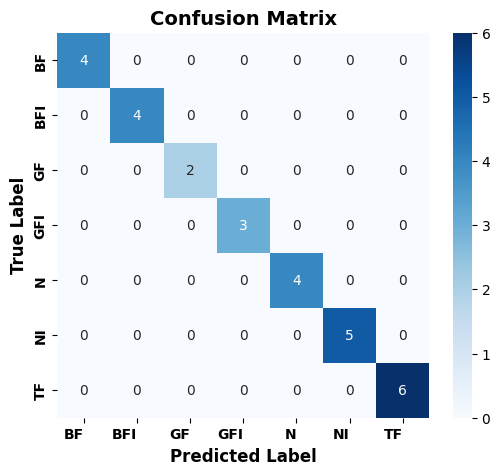

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Correct class names based on your dataset
class_names = ["BF", "BFI", 
               "GF", "GFI", 
               "N", "NI", "TF"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label", fontsize=12, fontweight="bold")
plt.ylabel("True Label", fontsize=12, fontweight="bold")
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
plt.xticks(ha="right", fontsize=10, fontweight="bold")  # Rotate x-axis labels
plt.yticks(fontsize=10, fontweight="bold")
plt.show()


In [14]:
from sklearn.manifold import TSNE

# Extract features from the last layer
features = []
labels_list = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        
        # Extract features before the final fully connected layer
        x = model.resnet.conv1(images)
        x = model.resnet.bn1(x)
        x = model.resnet.relu(x)
        x = model.resnet.maxpool(x)
        x = model.resnet.layer1(x)
        x = model.resnet.layer2(x)
        x = model.resnet.layer3(x)
        x = model.resnet.layer4(x)
        x = model.resnet.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten feature maps
        features.append(x.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Flatten lists
features = np.vstack(features)
labels_list = np.hstack(labels_list)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels_list, palette="coolwarm", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Feature Distribution")
plt.legend(class_names)
plt.show()


ValueError: perplexity must be less than n_samples

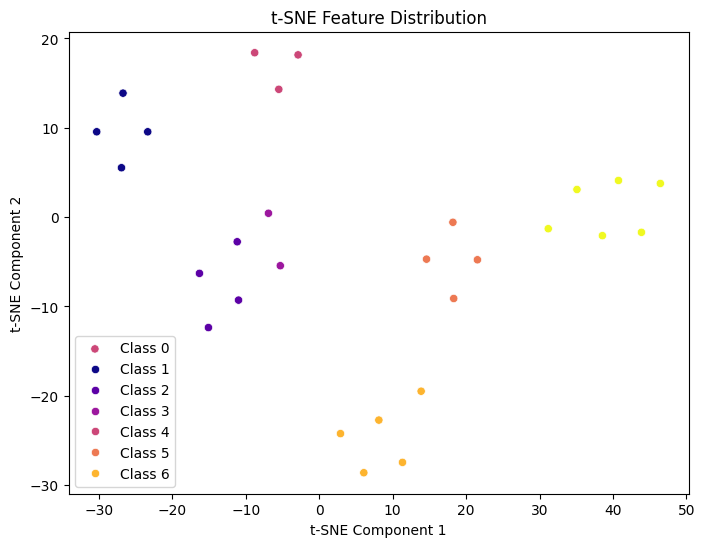

In [20]:
from sklearn.manifold import TSNE

# Ensure perplexity is valid
num_samples = features.shape[0]
perplexity_value = min(30, num_samples // 3)  # Auto-adjust perplexity

# Apply t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels_list, palette="plasma")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Feature Distribution")
plt.legend(["Class " + str(i) for i in range(num_classes)])
plt.show()


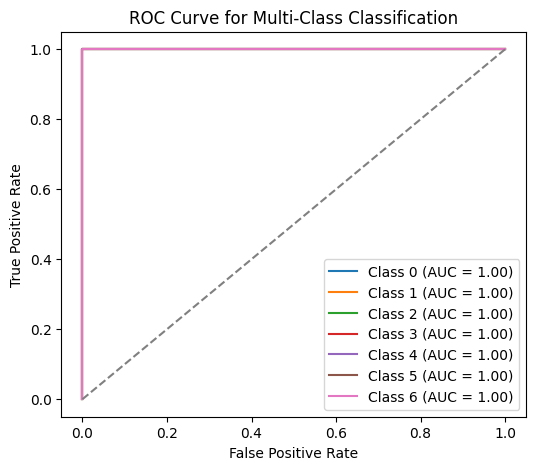

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))

# Compute ROC for each class
plt.figure(figsize=(6, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], np.array(all_preds) == i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()


In [17]:

import numpy as np
import collections

# Count occurrences of each class in test set
test_class_counts = collections.Counter(all_labels)
print("Test Set Class Distribution:", dict(test_class_counts))


Test Set Class Distribution: {3: 3, 6: 6, 0: 4, 4: 4, 5: 5, 2: 2, 1: 4}


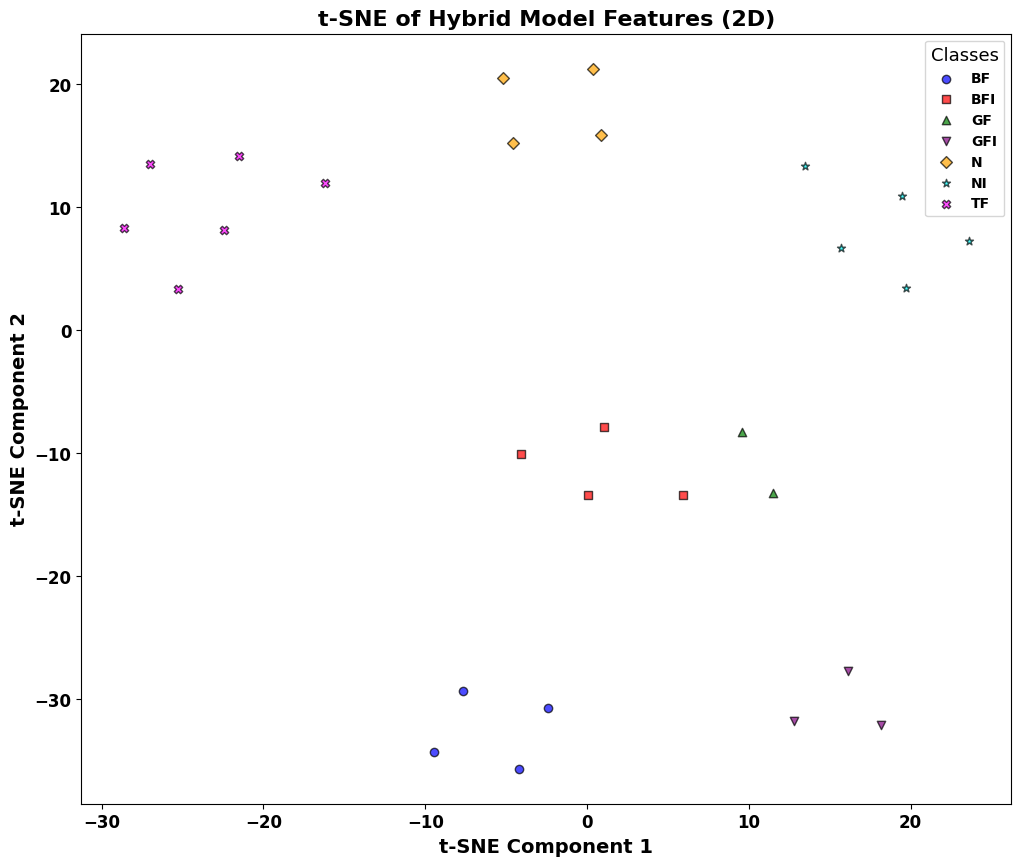

In [23]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

# Extract features and labels
features, labels_val = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = model(images)  # Extract feature representations
        features.append(output.cpu().numpy())
        labels_val.append(labels.cpu().numpy())

# Convert lists to arrays
features = np.concatenate(features)
labels_val = np.concatenate(labels_val)

# Reshape features for t-SNE
features_val = features.reshape(features.shape[0], -1)

# Apply t-SNE (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, features_val.shape[0] // 3))
features_tsne = tsne.fit_transform(features_val)

# Plot the t-SNE results for 7 classes
plt.figure(figsize=(12, 10))

# Define class names, markers, and colors for 7 classes
class_names = ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']
markers = ['o', 's', '^', 'v', 'D', '*', 'X']  # Different markers for each class
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta']

# Loop over each class and plot with specific markers and colors
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (labels_val == class_idx)  # Mask for the current class
    plt.scatter(features_tsne[class_mask, 0], features_tsne[class_mask, 1], 
                marker=marker, color=color, label=class_name, alpha=0.7, edgecolors='black')

# Add legend
plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='13')

# Add title and labels
plt.title('t-SNE of Hybrid Model Features (2D)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')

# Make the axis tick labels bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the figure
#plt.savefig('tsne_2d_hybrid_model_7_classes.png', dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()


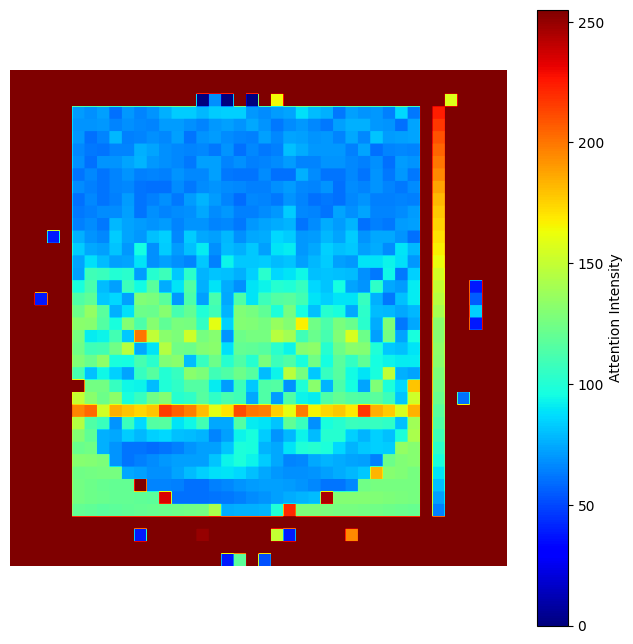

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r"E:\3 Paper MCT\data\TF_channel4_FFT\channel4\Sample_81.png"  # Update with your path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize to a low-resolution attention map (e.g., 10x10)
attention_map_size = (40, 40)  # Change this for different resolutions
attention_map = cv2.resize(image, attention_map_size, interpolation=cv2.INTER_NEAREST)

# Resize back to a larger size for visualization
resized_attention_map = cv2.resize(attention_map, (400, 400), interpolation=cv2.INTER_NEAREST)

# Display the attention map
plt.figure(figsize=(8, 8))
plt.imshow(resized_attention_map, cmap="jet")  # Jet colormap for attention effect
plt.colorbar(label="Attention Intensity")
plt.axis("off")
plt.show()


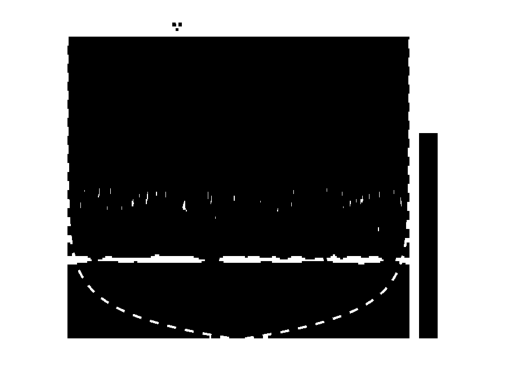

Mask saved at: E:\3 Paper MCT\data\TF_channel4_FFT\channel4\Sample_81_mask.png


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r"E:\3 Paper MCT\data\TF_channel4_FFT\channel4\Sample_81.png"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
_, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply morphological operations to clean the mask
kernel = np.ones((5, 5), np.uint8)
cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# Save the mask
mask_path = image_path.replace(".png", "_mask.png")
cv2.imwrite(mask_path, cleaned_mask)

# Display the original and mask images


plt.imshow(cleaned_mask, cmap="gray")
plt.axis("off")

plt.show()

print(f"Mask saved at: {mask_path}")
